In [2]:
%%bash
git clone 'https://github.com/ostojanovic/BSTIM.git'
git clone 'https://github.com/dgiri1/Covid---19.git'

fatal: destination path 'BSTIM' already exists and is not an empty directory.
Cloning into 'Covid---19'...


In [0]:
import numpy as np
import pandas as pd
import pickle
import shutil

In [0]:
## read the npy data 
file_interaction = '/content/BSTIM/data/counties/interaction_effects.npy'
file_counties = '/content/BSTIM/data/counties/counties.pkl'
interaction = np.load(file_interaction)
# open a file, where you stored the pickled data
file = open(file_counties, 'rb')

# dump information to that file
counties_data = pickle.load(file)

# close the file

file.close()

In [0]:
import pickle as pkl, pandas as pd, numpy as np, json, csv ,random, timeit, re

from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from descartes import PolygonPatch

from collections import OrderedDict

import matplotlib as mpl
from matplotlib import pyplot as plt

from collections import OrderedDict

In [0]:
%run '/content/BSTIM/src/geo_utils.py'

In [0]:

num_testpoints_per_state = 500
num_partition_samples = 50

num_interaction_gaussians = 4
interaction_distance = 1000.0 #[km]
σs= 2**np.arange(num_interaction_gaussians)/(2*num_interaction_gaussians)*interaction_distance

# states = OrderedDict()

In [0]:

with open("/content/Covid---19/data/gz_2010_us_040_00_500k.json", 'r') as data_file:
    shape_data = json.load(data_file)

for idx,val in enumerate(shape_data["features"]):
    id_current = val["properties"]["GEO_ID"]
    name_current = val["properties"]["NAME"]
    
    if val["geometry"]["type"] == "Polygon":
        polygon_current = Polygon(val["geometry"]["coordinates"][0],val["geometry"]["coordinates"][1:])
    elif val["geometry"]["type"] == "MultiPolygon":
        polys = [Polygon(p[0], p[1:]) for p in val["geometry"]["coordinates"]]
        polygon_current = MultiPolygon(polys)
    
    states[id_current] = {"shape": polygon_current, "name": name_current}

In [0]:
# Sanity check: the state 23 is Maine
assert states["0400000US23"]["name"] == "Maine"

In [0]:

state_names = dict([(val["name"], id) for id,val in states.items()])

In [0]:

age_data = pd.read_csv("Covid---19/data/sc-est2018-agesex-civ.csv")[["NAME","AGE","SEX","POPEST2018_CIV"]]

def merge_age_groups(age_group):
    starting_age = int(age_group)
    
    if starting_age <5:
        return "[0-5)"
    elif starting_age <20:
        return "[5-20)"
    elif starting_age < 65:
        return "[20-65)"
    else:
        return ">65"

age_data["AGE"] = age_data["AGE"].apply(merge_age_groups)

age_data["id"] = age_data["NAME"].apply(state_names.get)
age_data.rename(columns={'POPEST2018_CIV':'population'},inplace=True)
#get total number of people per county per year
total_population_data = age_data.groupby(["id"]).aggregate({"population": 'sum'})
#get total number of people per county per age group per year
group_population_data = age_data.groupby(["id","AGE"]).aggregate({"population": 'sum'})

#calculate the log age group fraction of the total population
log_group_fraction_data = group_population_data.apply(lambda row: np.log(row/total_population_data.loc[row.name[0]]),axis=1)#.loc[(row.name[0],row.name[2])]), axis=1)

#create group "total" column
total_population_data["AGE"]="total"
total_population_data.reset_index(inplace=True)
total_population_data.set_index(["id","AGE"], inplace=True)

#combine age groups and the "total" column into a single dataframe and export the "population" column as values in a dictionary
population_data = pd.concat([log_group_fraction_data, total_population_data])
population_data.reset_index().set_index(["id","AGE"], inplace=True)

In [0]:
for id,row in population_data.unstack(1).iterrows():
    states[id]["demographics"] = row["population"].to_dict()

In [263]:
for i,(id, state) in enumerate(states.items()):
    print("Sampling testpoints for stete '{}' ({:.2f}%)            ".format(id, 100.0*i/len(states)), end="\r")
    # Sample uniformly in the region using local jacobian
    centroid = np.array(state["shape"].centroid)
    Σ_sq = jacobian_sq(centroid[1])
    Σ_sqinv = np.diag(1/np.diag(Σ_sq))
    
    x1,y1,x2,y2 = state["shape"].bounds
    p1 = np.array([x1,y1])
    p2 = np.array([x2,y2])
    
    p1_corrected = (p1-centroid).dot(Σ_sq)
    p2_corrected = (p2-centroid).dot(Σ_sq)
    
    dims = p2_corrected-p1_corrected
    
    # calculate testpoints
    testpoints = np.empty((num_testpoints_per_state, 2), np.float)
    
    cnt = 0
    while cnt < num_testpoints_per_state:
        tp = (np.random.rand(2)*dims).dot(Σ_sqinv) + p1
        if not state["shape"].contains(Point(tp)):
            continue
        testpoints[cnt, :] = tp
        cnt += 1

        states[id]["testpoints"] = testpoints

In [174]:
for key in states.keys():
  print((key,states[key]['name']))

('0400000US23', 'Maine')
('0400000US25', 'Massachusetts')
('0400000US26', 'Michigan')
('0400000US30', 'Montana')
('0400000US32', 'Nevada')
('0400000US34', 'New Jersey')
('0400000US36', 'New York')
('0400000US37', 'North Carolina')
('0400000US39', 'Ohio')
('0400000US42', 'Pennsylvania')
('0400000US44', 'Rhode Island')
('0400000US47', 'Tennessee')
('0400000US48', 'Texas')
('0400000US49', 'Utah')
('0400000US53', 'Washington')
('0400000US55', 'Wisconsin')
('0400000US72', 'Puerto Rico')
('0400000US24', 'Maryland')
('0400000US01', 'Alabama')
('0400000US02', 'Alaska')
('0400000US04', 'Arizona')
('0400000US05', 'Arkansas')
('0400000US06', 'California')
('0400000US08', 'Colorado')
('0400000US09', 'Connecticut')
('0400000US10', 'Delaware')
('0400000US11', 'District of Columbia')
('0400000US12', 'Florida')
('0400000US13', 'Georgia')
('0400000US15', 'Hawaii')
('0400000US16', 'Idaho')
('0400000US17', 'Illinois')
('0400000US18', 'Indiana')
('0400000US19', 'Iowa')
('0400000US20', 'Kansas')
('0400000U

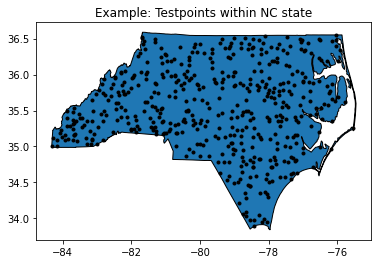

In [265]:
# plot for NC ('0400000US37', 'North Carolina')

ax = plt.subplot(111)
ax.add_patch(PolygonPatch(states["0400000US37"]["shape"]))
ax.plot(states["0400000US37"]["testpoints"][:,0],states["0400000US37"]["testpoints"][:,1], "k.")
ax.set_title("Example: Testpoints within NC state");

In [0]:
regions_df = pd.read_csv("/content/USregions.csv")
regions_df["id"] = regions_df["State"].apply(state_names.get)
regions_df.set_index("id",inplace=True)



In [267]:
regions_df.reset_index(inplace=True)
regions_df.set_index('Region').loc['West'].id.to_list()

['0400000US02',
 '0400000US04',
 '0400000US06',
 '0400000US08',
 '0400000US15',
 '0400000US16',
 '0400000US30',
 '0400000US35',
 '0400000US32',
 '0400000US41',
 '0400000US49',
 '0400000US53',
 '0400000US56']

In [0]:

regions = OrderedDict({
    "US":{"ids":list(states.keys()), "hatch": " "},
    "West": {"ids": regions_df.set_index('Region').loc['West'].id.to_list(), "hatch": "+"},
    "South": {"ids": regions_df.set_index('Region').loc['South'].id.to_list(), "hatch": "\\"},
    "Northeast": {"ids": regions_df.set_index('Region').loc['Northeast'].id.to_list(), "hatch": "/"},
    "Midwest":  {"ids": regions_df.set_index('Region').loc['Midwest'].id.to_list(), "hatch": "o"},
    "Other": {"ids": ['0400000US72'],"hatch": "--"}
})

In [0]:
for state in states.values():
    state["region"] = []

for region, props in regions.items():
    for id in props["ids"]:
        states[id]["region"].append(region)


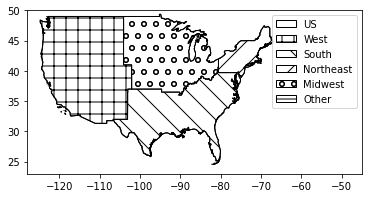

In [270]:
ax = plt.subplot(111)
# calculate region polygons
for name,region in regions.items():
    region_poly = Polygon()
    for c in region["ids"]:
        region_poly = region_poly.union(states[c]["shape"])

    # simplify polygon structure
    region_poly = region_poly.buffer(0.01).simplify(0.01).buffer(-0.01)

    region["shape"] = region_poly
    patch = PolygonPatch(region_poly, fill=False, label=name, hatch=region["hatch"])
    ax.add_patch(patch)

ax.legend()
ax.set_aspect(1.5)
y_lim = (23, 50) # lat 
x_lim = (-128, -45) # long
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
plt.show()

In [0]:

# precomputed noise
ϵ = np.random.randn(num_partition_samples, 2)

for i,(id,state) in enumerate(states.items()):
  state["borderloss"] = {}
  for j,(name,region) in enumerate(regions.items()):
    if id not in region["ids"]:
      continue
    print("Calculating border effects for state '{}' in region '{}' ({:.2f}%) ".format(id, name, 100.0*((i*len(regions)+j)/(len(states)*len(regions)))), end="\r")
    state["borderloss"][name] = compute_loss(region["shape"], state["testpoints"], σs, ϵ)

In [0]:
cmap = mpl.cm.ScalarMappable(cmap=mpl.cm.viridis)
cmap.set_clim(0.0, 1.0)

fig = plt.figure(figsize=(5*len(σs), 5*len(regions)))
# calculate region polygons
for i,r in enumerate(regions.keys()):
    for j,σ in enumerate(σs):
        ax = fig.add_subplot(len(regions), 4, i*4+j+1, aspect=1.0)
        for k,(rid, state) in enumerate(states.items()):
            if r in state["borderloss"]:
                ax.add_patch(PolygonPatch(state["shape"], lw=0, fc=cmap.to_rgba(state["borderloss"][r][j])))
            else:
                ax.add_patch(PolygonPatch(state["shape"], lw=0, fill=False, hatch="x"))
        ax.set_aspect(1.5)
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_title("{} @ σ = {:.2f}".format(r,σ))
plt.show(fig)

In [0]:
with open('/content/Covid---19/data/states.pkl',"wb") as f:
    pkl.dump(states,f)

In [312]:
factor = np.empty((len(states),len(states),len(σs)), np.float64)

for i,(id_1, state_1) in enumerate(states.items()):
    for j,(id_2, state_2) in enumerate(states.items()):
        if j < i:
            factor[i,j,:] = factor[j,i,:]
            continue
        print("Calculating interaction effects for states '{}' and '{}' ({:.2f}%)            ".format(id_1, id_2, 100.0*(i+j/len(states))/len(states)), end="\r")
        factor[i,j,:] = compute_interaction(state_1["testpoints"], state_2["testpoints"], σs)

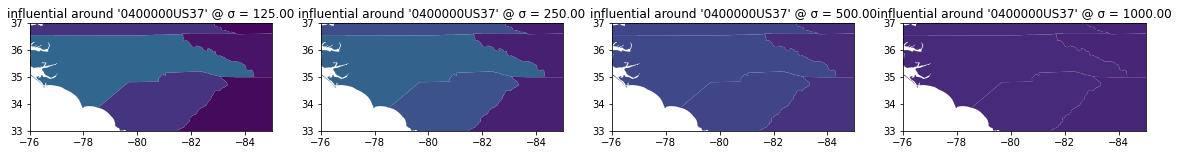

In [313]:
cmap = mpl.cm.ScalarMappable(cmap=mpl.cm.viridis)
cmap.set_clim(factor.min(), factor.max())

i = list(states.keys()).index("0400000US37")

fig = plt.figure(figsize=(5*len(σs), 5))
for j,σ in enumerate(σs):
    ax = fig.add_subplot(1, len(σs), j+1, aspect=1.0)
    for k,(rid, state) in enumerate(states.items()):
        ax.add_patch(PolygonPatch(state["shape"], lw=0, fc=cmap.to_rgba(factor[i,k,j])))
    ax.set_aspect(1.0)
    ax.set_xlim(-76,-85)
    ax.set_ylim(33,37)
    ax.set_title("influential around '0400000US37' @ σ = {:.2f}".format(σ))
plt.show(fig)

In [0]:
np.save("/content/Covid---19/data/interaction_effects.npy", factor)